In [28]:
%matplotlib inline
import diogenes.read as read
import diogenes.display as display
import diogenes.modify as modify
import diogenes.utils as utils
import diogenes.grid_search as grid_search
import numpy as np

### Methods

1. Data obtained from the [Citizens Police Data Project](cpdb.co).
2. This data includes only the FOIA dataset from 2011 to present (i.e. the Bond and Moore datasets have been removed). 
3. This was accomplished by entering FOIA in the search bar.
4. The resulting table was saved locally as a .xslx.
5. The Allegations, Complaining Witnesses, and Officer Profile tabs were then saved locally as allegations.csv, citizens.csv, and officers.csv respectively.


### Disclaimer

The following disclaimer is included with the data by the [Invisible Institute](http://invisible.institute).


This dataset is compiled from three lists of allegations against Chicago Police Department officers,
spanning approximately 2002 - 2008 and 2010 - 2014, produced by the City of Chicago in response
to litigation and to FOIA requests.

The City of Chicago's production of this information is accompanied by a disclaimer that
not all information contained in the City's database may be correct.

No independent verification of the City's records has taken place and this dataset does not
purport to be an accurate reflection of either the City's database or its veracity.

In [29]:
#Record arrays
allegations = read.open_csv('allegations.csv',parse_datetimes=['IncidentDate','StartDate','EndDate'])
citizens = read.open_csv('citizens.csv')
officers = read.open_csv('officers.csv')

### What data do we have?

We can see the column names for the three tables below.

1. The Allegations table includes data on each allegation, including an ID for the complaint witness, the officer, and the outcome of the allegation. 
2. The Citizens table includes additional information for each complaint witness.
3. The Officers table includes additional information for each officer.

In [30]:
#I shouldn't have to nest function calls just to get a summary of my data. This needs to be a single call.
#Most of the data isn't numeric, so we should find a way to be more helpful than this.
#Also, what is the "None" printing at the end of this?
print display.pprint_sa(display.describe_cols(allegations))
print display.pprint_sa(display.describe_cols(citizens))
print display.pprint_sa(display.describe_cols(officers))

          Column Name   Count          Mean Standard Dev Minimum     Maximum
 0               CRID 28575.0 1072720.56308 916800.77455  1074.0 107000321.0
 1          OfficerID 28575.0           nan          nan     1.0      9172.0
 2        OfficeFirst     nan           nan          nan     nan         nan
 3        OfficerLast     nan           nan          nan     nan         nan
 4     AllegationCode     nan           nan          nan     nan         nan
 5           Category     nan           nan          nan     nan         nan
 6         Allegation     nan           nan          nan     nan         nan
 7 RecommendedFinding     nan           nan          nan     nan         nan
 8 RecommendedOutcome 28575.0           nan          nan     0.0       800.0
 9       FinalFinding     nan           nan          nan     nan         nan
10       FinalOutcome 28575.0           nan          nan     0.0       999.0
11            Finding     nan           nan          nan     nan         nan

For this analysis, we will be removing several columns for the following reasons:

1. To anonymize our data, names of officers and investiagtors have been removed.
2. Many of the columns in Allegations are redundant as they code for other columns. We will preserve only the human readable columns.
3. The Beat column has no data, so it will be removed.
4. We will only focus on final outcomes, so the "recommended" columns have been removed from Allegations.
5. We will be limiting our geographic analysis to Location, so the address information has been removed.

We will also translate ApptDate, which specifies the number of days between the hire date and 1900-1-1, to the number of years working.

In [31]:
import datetime

#TODO: there is a typo in the "OfficerFirst" column in allegations.
#Should pass this on to Kalven at Invisible Institute along with questions about data.
allegations = utils.remove_cols(allegations,['OfficeFirst','OfficerLast','Investigator','AllegationCode','RecommendedFinding','RecommendedOutcome','FinalFinding','FinalOutcome','Beat','Add1','Add2','City'])  
officers = utils.remove_cols(officers,['OfficerFirst','OfficerLast','Star'])

#Convert appointment date days since 1900-1-1 to years prior to today
def tenure(vector):
    today = datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d')
    started = np.add(np.datetime64('1900-01-01'),map(lambda x: np.timedelta64(int(x), 'D'),vector))
    tenure = np.subtract(np.datetime64(today),started)
    return np.divide(tenure,np.timedelta64(1,'D')) / 365

#Impute median date for missing values
officers['ApptDate'] = modify.replace_missing_vals(officers['ApptDate'], strategy='median')
tenure_days = modify.combine_cols(officers,tenure,['ApptDate'])
officers = utils.append_cols(officers,[tenure_days],['Tenure'])


For ease of use, let's join our tables.

In [32]:
master = utils.join(allegations,citizens,'left',['CRID'],['CRID'])

#Rename Race and Gender, since citizens and officers have these columns
temp_col_names = list(master.dtype.names)
gender_index = temp_col_names.index("Gender")
race_index = temp_col_names.index("Race")
temp_col_names[gender_index] = "CitizenGender"
temp_col_names[race_index] = "CitizenRace"
master.dtype.names = tuple(temp_col_names)

master = utils.join(master,officers,'left',['OfficerID'],['OfficerID'])

temp_col_names = list(master.dtype.names)
gender_index = temp_col_names.index("Gender")
race_index = temp_col_names.index("Race")
temp_col_names[gender_index] = "OfficerGender"
temp_col_names[race_index] = "OfficerRace"
master.dtype.names = tuple(temp_col_names)

There are some allegations where no officer ID was provided. For this analysis, we will discard those allegations.

In [33]:
#This is a pretty awkward way to remove nan, is there a better way I missed?
master = modify.choose_rows_where(master,[{'func': modify.row_val_between, 'col_name': 'OfficerID', 'vals': [-np.inf,np.inf]}])

Now, let's encode our data numerically

In [34]:
#Unit is interpreted as numeric, but we really want to analyze it categorically
#There should be an easier way to treat a numeric column as categorical data
master = utils.append_cols(master,master['Unit'].astype('|S10'),['UnitCat'])
master = utils.remove_cols(master,['Unit'])
master_data, master_classes = modify.label_encode(master)

For convenience, we'll build every possible categorical directive

In [35]:
#Directives

def cat_directives(array,classes):
    cat_directives = {}
    for column in classes:
        cat_directives[column] = {v:[{'func': modify.row_val_eq, 'col_name': column, 'vals': i}] for i,v in enumerate(classes[column])}
    return cat_directives

where = cat_directives(master_data,master_classes)

Now, we can build intuitive masks as combinations of our human-readable directives

In [36]:
#Masks

#Gender
female_officers = modify.where_all_are_true(master_data,where['OfficerGender']['F'])
male_officers = modify.where_all_are_true(master_data,where['OfficerGender']['M'])

female_citizens = modify.where_all_are_true(master_data,where['CitizenGender']['F'])
male_citizens = modify.where_all_are_true(master_data,where['CitizenGender']['M'])

#Race
white_officers = modify.where_all_are_true(master_data,where['OfficerRace']['White'])
black_officers = modify.where_all_are_true(master_data,where['OfficerRace']['Black'])
hispanic_officers = modify.where_all_are_true(master_data,where['OfficerRace']['Hispanic'])

white_citizens = modify.where_all_are_true(master_data,where['CitizenRace']['White'])
black_citizens = modify.where_all_are_true(master_data,where['CitizenRace']['Black'])
hispanic_citizens = modify.where_all_are_true(master_data,where['CitizenRace']['Hispanic'])

#Cross-sections
white_M_officers_black_F_citizens = modify.where_all_are_true(master_data,where['OfficerRace']['White']+
                                                                          where['OfficerGender']['M']+
                                                                          where['CitizenRace']['Black']+
                                                                          where['CitizenGender']['F'])


Let's generate a potentially interesting new feature from our existing data, and pull out all non-numeric data

In [37]:
duration = modify.combine_cols(master_data,np.subtract,['EndDate','StartDate'])
durationDays = duration / np.timedelta64(1, 'D')
duration_data = utils.append_cols(master_data,[durationDays],['InvestigationDuration'])
           
numeric_data = utils.remove_cols(master_data,['StartDate','EndDate','IncidentDate'])

We understand what data we have, and we have some tools to easily slice and dice. Let's dive in and learn something.

0.116281305581
[(6142.0, 32), (816.0, 28), (7006.0, 26), (4253.0, 25), (7383.0, 24), (2657.0, 22), (1095.0, 21), (4304.0, 21), (8308.0, 21), (2400.0, 20), (3785.0, 20), (715.0, 19), (1979.0, 19), (3667.0, 19), (5143.0, 19), (5194.0, 19), (7555.0, 19), (1718.0, 18), (6390.0, 18), (930.0, 17), (5558.0, 17), (260.0, 16), (344.0, 16), (981.0, 16), (1178.0, 16), (1982.0, 16), (2329.0, 16), (4088.0, 16), (4438.0, 16), (1141.0, 15), (2123.0, 15), (2492.0, 15), (2928.0, 15), (3078.0, 15), (3490.0, 15), (6555.0, 15), (8046.0, 15), (290.0, 14), (496.0, 14), (1020.0, 14), (1045.0, 14), (1111.0, 14), (1125.0, 14), (1209.0, 14), (2215.0, 14), (2887.0, 14), (3323.0, 14), (4592.0, 14), (4796.0, 14), (5102.0, 14), (5513.0, 14), (6554.0, 14), (1019.0, 13), (1037.0, 13), (1316.0, 13), (1668.0, 13), (1808.0, 13), (2334.0, 13), (2354.0, 13), (3958.0, 13), (3962.0, 13), (4176.0, 13), (4812.0, 13), (4969.0, 13), (5843.0, 13), (6388.0, 13), (6793.0, 13), (7554.0, 13), (7594.0, 13), (87.0, 12), (115.0, 12), (

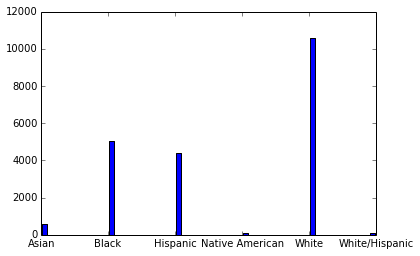

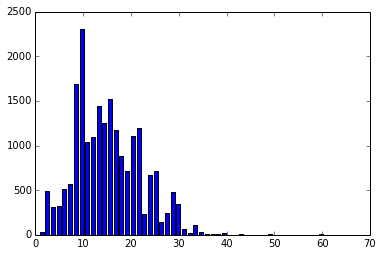

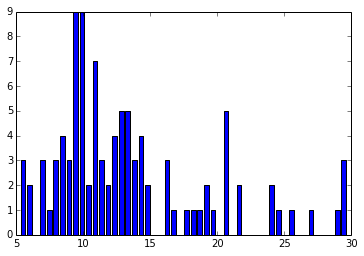

In [38]:
# Basics

#Ex 1: What percentage of allegations have a black female citizen and a white male officer?
print np.sum(white_M_officers_black_F_citizens.astype(np.float))/np.size(white_M_officers_black_F_citizens.astype(np.float))

#Ex 2: What is the breakdown of officers with complaints by race?
#This seems a little clunky to me
#Would be nice if plot_simple_histogram could handle categorical labels for me
display.plot_simple_histogram(master_data['OfficerRace'],verbose=False)
display.plt.xticks(range(len(master_classes['OfficerRace'])), master_classes['OfficerRace'])

#Ex 3: What can we learn from the 100 officers who receive the most complaints?
#FYI: Wikipedia says 12,244 officers total, so this is roughly the top 1% of all Chicago officers.
#Obviously, all officers do not have the same quantity and quality of interactions with citizens.
#Need to account for this fact for any real analysis.
counts = display.Counter(numeric_data['OfficerID'])
        
#Top 100 Officers
top_100 = counts.most_common(100)
top_100_officers = map(lambda x: x[0],top_100)

#We should add this to modify.py for categorical data
def row_val_in(M,col_name,boundary):
    return [x in boundary for x in M[col_name]]

top_100_profile = modify.choose_rows_where(officers,[{'func': row_val_in, 'col_name': 'OfficerID', 'vals': top_100_officers}])

#Can't check this against CPDB, their allegation counts are for the whole time period
#Not just 2011 - present.
print top_100

display.plot_simple_histogram(master_data['Tenure'],verbose=False)
display.plot_simple_histogram(top_100_profile['Tenure'],verbose=False)



In [39]:
#Hastily written, possibly not useful. Just curious.
def sortedFrequencies(array,classes,col_name):
    if col_name not in classes:
        raise ValueError('col_name must be categorical')
    
    counts = display.Counter(array[col_name])
    total = float(sum(counts.values()))
    
    for key in counts:
         counts[key] /= total
    
    count_dict = {}    
    for value in counts:
        count_dict[classes[col_name][value]] = counts[value]
        
    return sorted(count_dict.items(), key=lambda x: x[1],reverse=True)

print sortedFrequencies(numeric_data,master_classes,'Outcome')
    

[('No Action Taken', 0.7631110897466712), ('Unknown', 0.19896168821804547), ('Reprimand', 0.010623467769071769), ('Violation Noted', 0.006874008556458203), ('1 Day Suspension', 0.00475892900062491), ('Resigned', 0.0038936691823294716), ('5 Day Suspension', 0.002355429505359804), ('2 Day Suspension', 0.002018939576022689), ('Penalty Not Served', 0.0016343796567802721), ('3 Day Suspension', 0.001201749747632553), ('10 Day Suspension', 0.0007691198384848339), ('15 Day Suspension', 0.0007210498485795318), ('', 0.0004326299091477191), ('20 Day Suspension', 0.0004326299091477191), ('30 Day Suspension', 0.00038455991924241697), ('25 Day Suspension', 0.00033648992933711484), ('Administrative Termination', 0.00033648992933711484), ('4 Day Suspension', 0.0002884199394318127), ('Separation', 0.00014420996971590636), ('45 Day Suspension', 0.00014420996971590636), ('Suspended over 30 Days', 0.00014420996971590636), ('Reinstated by Police Board', 9.613997981060424e-05), ('21 Day Suspension', 9.61399